In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import random

from rdkit import Chem
import shap
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from rdkit import Chem
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.manifold import TSNE
import umap

In [3]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight

In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed()

In [5]:
sys.path.append('../')

In [6]:
from scripts.utils import (
    remove_ambiguous_smiles, form_data,
    balance_with_interpolate, featurize_ecfp4, compute_metrics, balance_classes,
    train_test_split, embeddings_dict_to_df, expand_embeddings, embeddings_dict_to_df, filter_and_log, is_valid_organic_smiles
)

In [7]:
df = pd.read_csv('../data/tox_dataset.csv')

Выволнение фильтрации датасета по критериям:
* Некорректных smiles
* То, что не удалось кекулизировать
* Не удалось удалить атом водорода

In [8]:
processed_df, logs = filter_and_log(df)

Filtering molecules:   0%|          | 0/8485 [00:00<?, ?it/s]

Filtering molecules: 100%|██████████| 8485/8485 [02:25<00:00, 58.42it/s] 

Delta: 98.43%


In [9]:
for idx in processed_df.index:
    if idx in logs:
        print(logs[idx])

В данных есть NA значения

In [10]:
processed_df.isna().sum()

SMILES         0
toxicity    1610
mol            0
dtype: int64

In [11]:
df_copied = processed_df.copy()
df_copied = df_copied.reset_index(drop=True)

In [12]:
df_copied = remove_ambiguous_smiles(df_copied)  # удаление дубликатов и противоречивых SMILES
df_copied = df_copied.sample(frac=1, random_state=42)
organic_smiles_idx = df_copied['SMILES'].apply(is_valid_organic_smiles) # проверка на органические соединения

In [13]:
organic_smiles_idx.sum() / len(df_copied)

0.9904149159663865

Органических молекул 99%, соли и металлы не буду учитывать

In [14]:
df_organic = df_copied[organic_smiles_idx].copy()

### Train test split

In [15]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    scaf = MurckoScaffold.MakeScaffoldGeneric(
        MurckoScaffold.GetScaffoldForMol(mol)
    )
    return Chem.MolToSmiles(scaf)

* Murcko Scaffold — это каркас молекулы, состоящий из:
* кольцевых структур (rings)
* линкеров между кольцами (linkers)
* удаляются все боковые цепи (side chains)

In [16]:
df_organic['scaffold'] = df_organic['SMILES'].apply(scaffold)  # создание скаффолдов для органических соединений

In [17]:
df_organic_cleaned = df_organic.dropna().reset_index(drop=True)  # удаление строк с NaN

In [26]:
df_organic_cleaned.to_csv('../data/df_organic_cleaned.csv', index=False)

In [18]:
df_organic_cleaned['toxicity'].value_counts()

toxicity
0.0    5180
1.0     768
Name: count, dtype: int64

In [19]:
scaffold_counts = df_organic_cleaned['scaffold'].value_counts().sort_values(ascending=False)

Часто встречаемые скаффолды

/tmp/ipykernel_1942227/1095905261.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scaffold_counts.head(top_n).values, y=scaffold_counts.head(top_n).index, palette='viridis')


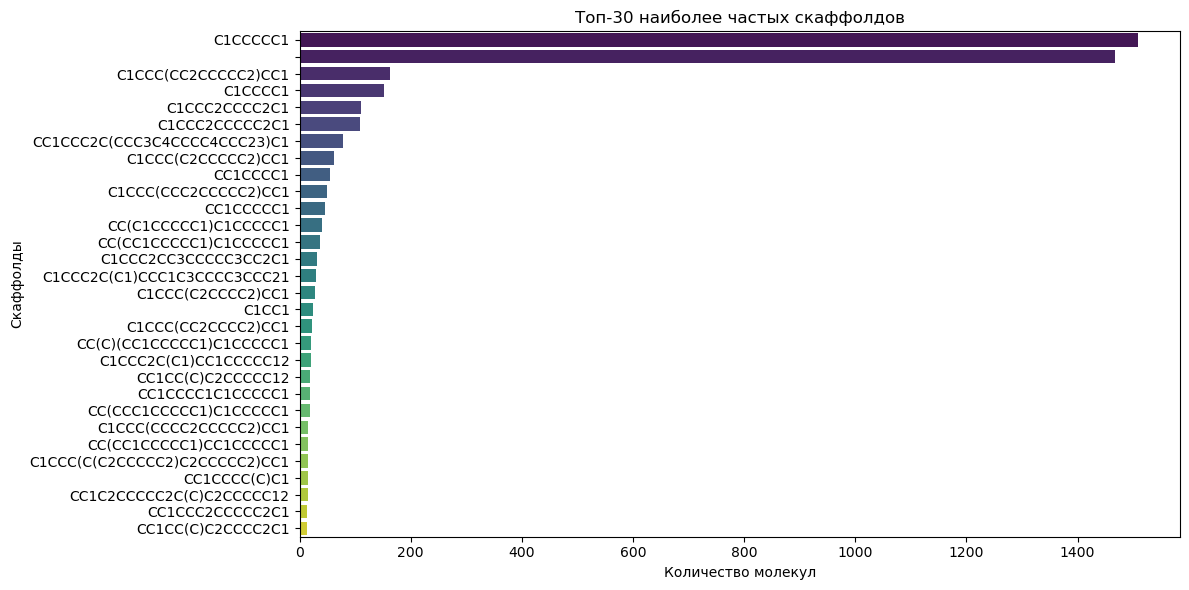

In [20]:
top_n = 30
plt.figure(figsize=(12, 6))
sns.barplot(x=scaffold_counts.head(top_n).values, y=scaffold_counts.head(top_n).index, palette='viridis')

plt.xlabel('Количество молекул')
plt.ylabel('Скаффолды')
plt.title(f'Топ-{top_n} наиболее частых скаффолдов')
plt.tight_layout()
plt.show()

In [30]:
scaffold_label_counts = df_organic_cleaned.groupby('scaffold')['toxicity'].nunique()
scaffold_label_counts = scaffold_label_counts.value_counts()

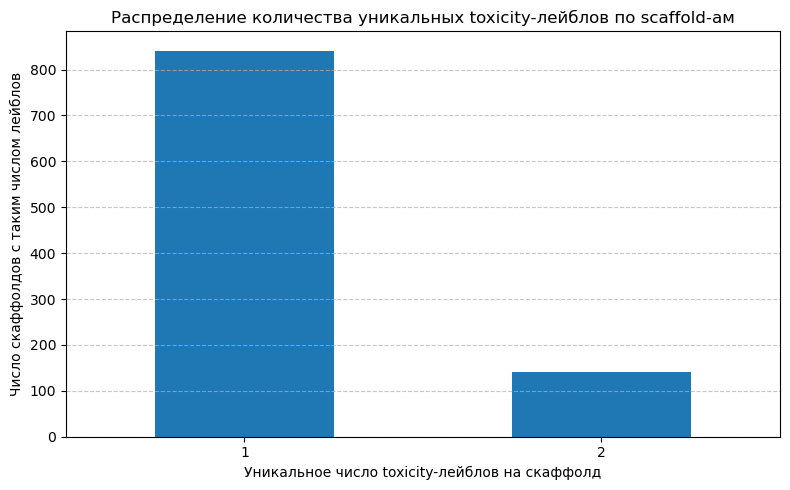

In [31]:
scaffold_label_counts = scaffold_label_counts.sort_index()

# Построение графика
plt.figure(figsize=(8, 5))
scaffold_label_counts.plot(kind='bar')
plt.xlabel('Уникальное число toxicity-лейблов на скаффолд')
plt.ylabel('Число скаффолдов с таким числом лейблов')
plt.title('Распределение количества уникальных toxicity-лейблов по scaffold-ам')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [32]:
ratio = scaffold_label_counts[2] / scaffold_label_counts.sum()
ratio

0.14271151885830785

Только 14 процентов скаффолдов включают токсичные и нетоксичные молекулы, скаффолд во много определяет значение таргета

### Random Random stratified train test split 

In [21]:
X_ecfp = np.vstack([featurize_ecfp4(m) for m in df_organic_cleaned['mol']])
y = df_organic_cleaned['toxicity'].values
groups = df_organic_cleaned['scaffold'].values

In [22]:
train_idx_random, test_idx_random = train_test_split(X_ecfp, y, n_splits=6)
df_train_random_split, df_test_random_split = form_data(df_organic_cleaned, train_idx_random, test_idx_random)

In [23]:
df_train_random_split['toxicity'].value_counts()

toxicity
0.0    4316
1.0     640
Name: count, dtype: int64

In [96]:
model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2,
                               oob_score=True,
                               n_jobs=-1)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_random_split['mol']])
y_train = df_train_random_split['toxicity'].values
model.fit(X_train, y_train)

oob_proba = model.oob_decision_function_[:, 1]
oob_pred = (oob_proba >= 0.5).astype(int)
compute_metrics(y_train, oob_pred, oob_proba)

{'precision': 0.8357142857142857,
 'recall': 0.1828125,
 'sensitivity': 0.9946709916589435,
 'f1': 0.3,
 'roc_auc': 0.740469329240037}

In [97]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.8888888888888888,
 'recall': 0.125,
 'sensitivity': 0.9976851851851852,
 'f1': 0.2191780821917808,
 'roc_auc': 0.7147623697916666}

In [65]:
df_train_oversampled = balance_classes(df_train_random_split, target_col='toxicity', method='oversample')

model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2,
                               n_jobs=-1)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_oversampled['mol']])
y_train = df_train_oversampled['toxicity'].values
model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [53]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.3790322580645161,
 'recall': 0.3671875,
 'sensitivity': 0.9108796296296297,
 'f1': 0.373015873015873,
 'roc_auc': 0.7447916666666665}

In [54]:
df_train_undersampled = balance_classes(df_train_random_split, target_col='toxicity', method='undersample')

model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2,
                               oob_score=True,
                               n_jobs=-1)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_undersampled['mol']])
y_train = df_train_undersampled['toxicity'].values
model.fit(X_train, y_train)
oob_proba = model.oob_decision_function_[:, 1]
oob_pred = (oob_proba >= 0.5).astype(int)
compute_metrics(y_train, oob_pred, oob_proba)

{'precision': 0.7027972027972028,
 'recall': 0.628125,
 'sensitivity': 0.734375,
 'f1': 0.6633663366336634,
 'roc_auc': 0.7397705078125001}

In [ ]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.2183288409703504,
 'recall': 0.6328125,
 'sensitivity': 0.6643518518518519,
 'f1': 0.3246492985971944,
 'roc_auc': 0.7092194733796298}

In [64]:
X_train = np.vstack([featurize_ecfp4(m) for m in df_train_random_split['mol']])
df_trained_featurized = pd.DataFrame(X_train)
df_trained_featurized['toxicity'] = df_train_random_split['toxicity'].values
df_trained_featurized_smote = balance_with_interpolate(df_trained_featurized, class_balancer=SMOTE)

model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2,
                               n_jobs=-1)

X_train = df_trained_featurized_smote.drop(columns=['toxicity']).values
y_train = df_trained_featurized_smote['toxicity'].values
model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [57]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.35384615384615387,
 'recall': 0.359375,
 'sensitivity': 0.9027777777777778,
 'f1': 0.35658914728682173,
 'roc_auc': 0.692554615162037}

In [63]:
df_trained_featurized_adasyn = balance_with_interpolate(df_trained_featurized, class_balancer=ADASYN)

model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2,
                               n_jobs=-1)

X_train = df_trained_featurized_adasyn.drop(columns=['toxicity']).values
y_train = df_trained_featurized_adasyn['toxicity'].values
model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [59]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.373134328358209,
 'recall': 0.390625,
 'sensitivity': 0.9027777777777778,
 'f1': 0.3816793893129771,
 'roc_auc': 0.6815411603009258}

#### MACCSkeys

In [60]:
from rdkit.Chem import MACCSkeys

model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2, oob_score=True,
                               n_jobs=-1)

X_train = np.vstack([np.array(MACCSkeys.GenMACCSKeys(m)) for m in df_train_random_split['mol']])
y_train = df_train_random_split['toxicity'].values
model.fit(X_train, y_train)
oob_proba = model.oob_decision_function_[:, 1]
oob_pred = (oob_proba >= 0.5).astype(int)
compute_metrics(y_train, oob_pred, oob_proba)

{'precision': 0.75,
 'recall': 0.2109375,
 'sensitivity': 0.9895736793327155,
 'f1': 0.32926829268292684,
 'roc_auc': 0.7391196999536608}

In [61]:
X_test = np.vstack([np.array(MACCSkeys.GenMACCSKeys(m)) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.7647058823529411,
 'recall': 0.203125,
 'sensitivity': 0.9907407407407407,
 'f1': 0.32098765432098764,
 'roc_auc': 0.7206398292824073}

### Chem Bert embeddings

In [ ]:
embeddings = torch.load('../data/chemberta_embeddings.pt', weights_only=False)
embeddings_df = embeddings_dict_to_df(embeddings)
embeddings_df = expand_embeddings(embeddings_df)

In [76]:
df_train_embedded = df_train_random_split[['toxicity', 'SMILES']].merge(embeddings_df, on='SMILES').drop(columns=['SMILES'])
df_test_embedded = df_test_random_split[['toxicity', 'SMILES']].merge(embeddings_df, on='SMILES').drop(columns=['SMILES'])

In [77]:
model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2, oob_score=True,
                               n_jobs=-1)

X_train = df_train_embedded.drop(columns=['toxicity']).values
y_train = df_train_random_split['toxicity'].values
model.fit(X_train, y_train)
oob_proba = model.oob_decision_function_[:, 1]
oob_pred = (oob_proba >= 0.5).astype(int)
compute_metrics(y_train, oob_pred, oob_proba)

{'precision': 0.7828947368421053,
 'recall': 0.1859375,
 'sensitivity': 0.992354031510658,
 'f1': 0.3005050505050505,
 'roc_auc': 0.735846812731696}

In [79]:
X_test = df_test_embedded.drop(columns=['toxicity']).values
y_test = df_test_embedded['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.8518518518518519,
 'recall': 0.1796875,
 'sensitivity': 0.9953703703703703,
 'f1': 0.2967741935483871,
 'roc_auc': 0.7252242476851851}

### Визуализация эмбеддингов

In [80]:
df_embedded = pd.concat([df_train_embedded, df_test_embedded], ignore_index=True)

In [ ]:
def plot_embeddings(df: pd.DataFrame, method: str = "umap", target_col: str = "toxicity", n_samples: int = None):
    """
    Визуализирует эмбеддинги с помощью UMAP или t-SNE.

    Parameters:
    - df: DataFrame с эмбеддингами и колонкой target
    - method: "umap" или "tsne"
    - target_col: имя колонки с метками классов
    - n_samples: количество примеров для подвыборки (если dataset большой)
    """
    assert method in ["umap", "tsne"], "Метод должен быть 'umap' или 'tsne'"

    if n_samples is not None and n_samples < len(df):
        df = df.sample(n=n_samples, random_state=42)

    X = df.drop(columns=[target_col]).values
    y = df[target_col].values

    if method == "umap":
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    else:
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)

    X_reduced = reducer.fit_transform(X)

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette="Set1", alpha=0.7, edgecolor="k")
    plt.title(f"Визуализация эмбеддингов ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Класс")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

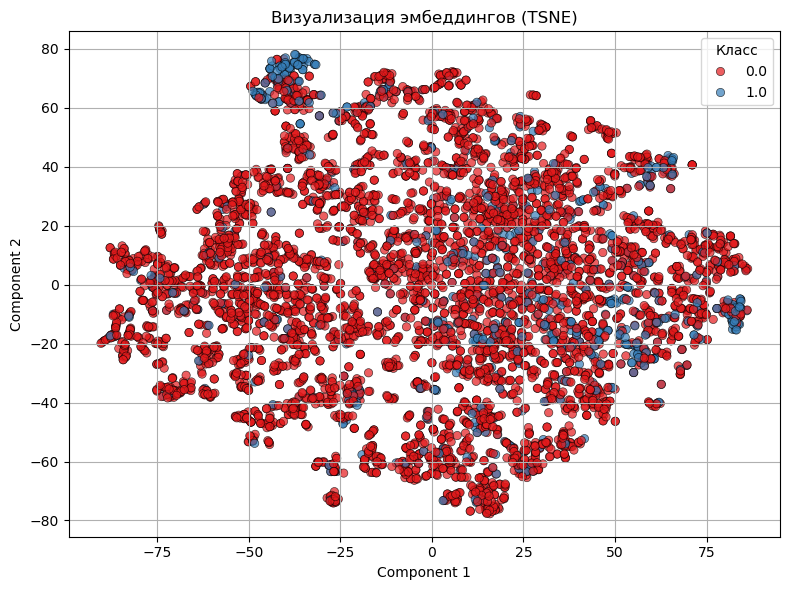

In [92]:
plot_embeddings(df_embedded, method="tsne")

/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


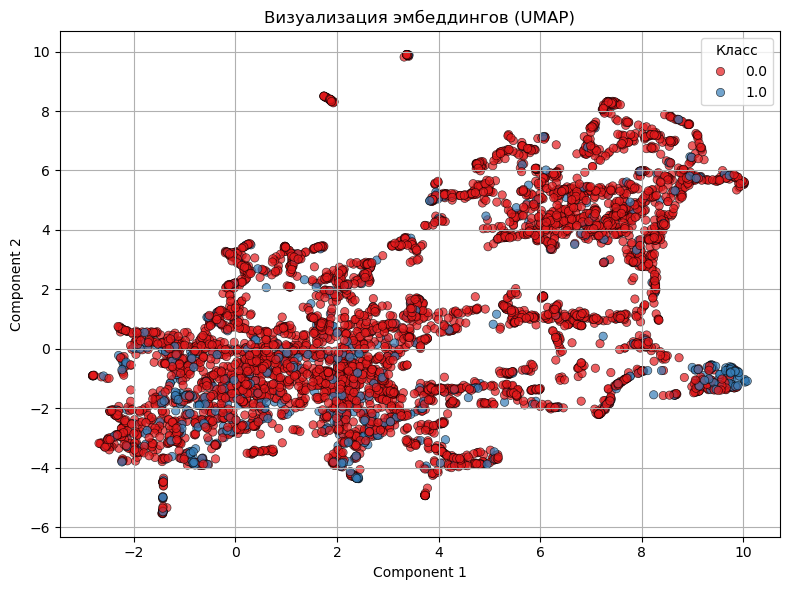

In [93]:
plot_embeddings(df_embedded, method="umap")

### MLP

In [83]:
class BinaryDataset(Dataset):
    def __init__(self, df, target_col='toxicity'):
        self.X = torch.tensor(df.drop(columns=[target_col]).values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [84]:
X_train = df_train_embedded.drop(columns=['toxicity']).values
y_train = df_train_embedded['toxicity'].values

In [85]:
train_idx_random, test_idx_random = train_test_split(X_train, y_train, n_splits=6)
df_train_embedded, df_valid_embedded = form_data(df_train_embedded, train_idx_random, test_idx_random)

In [87]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=df_train_embedded['toxicity'])
pos_weight = torch.tensor(class_weights[0] / class_weights[1])

In [88]:
train_dataset = BinaryDataset(df_train_embedded)
valid_dataset = BinaryDataset(df_valid_embedded)
test_dataset = BinaryDataset(df_test_embedded)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [89]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], dropout=0.3):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers += [
                nn.Linear(dims[i], dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
        layers.append(nn.Linear(dims[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [92]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device,
                n_epochs=50, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Валидация
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)
        print(f"[{epoch+1}] Train loss: {np.mean(train_losses):.4f}, Val loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model)
    return model


def evaluate(model, loader, device):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            y_score.extend(probs.flatten())
            y_pred.extend(preds.flatten())
            y_true.extend(y_batch.numpy().flatten())

    metrics = compute_metrics(y_true, y_pred, y_score)
    return metrics

In [ ]:
model = MLP(input_dim=df_train_embedded.shape[1] - 1).to(device)

In [91]:
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [93]:
model = train_model(model, train_loader, valid_loader, criterion, optimizer, device=device, n_epochs=100, patience=10)

[1] Train loss: 0.2065, Val loss: 0.0933
[2] Train loss: 0.0928, Val loss: 0.0910
[3] Train loss: 0.0878, Val loss: 0.0923
[4] Train loss: 0.0867, Val loss: 0.0898
[5] Train loss: 0.0848, Val loss: 0.0899
[6] Train loss: 0.0863, Val loss: 0.0896
[7] Train loss: 0.0848, Val loss: 0.0888
[8] Train loss: 0.0822, Val loss: 0.0897
[9] Train loss: 0.0817, Val loss: 0.0902
[10] Train loss: 0.0827, Val loss: 0.0897
[11] Train loss: 0.0798, Val loss: 0.0894
[12] Train loss: 0.0802, Val loss: 0.0886
[13] Train loss: 0.0795, Val loss: 0.0880
[14] Train loss: 0.0786, Val loss: 0.0883
[15] Train loss: 0.0784, Val loss: 0.0925
[16] Train loss: 0.0768, Val loss: 0.0907
[17] Train loss: 0.0777, Val loss: 0.0893
[18] Train loss: 0.0763, Val loss: 0.0890
[19] Train loss: 0.0735, Val loss: 0.0904
[20] Train loss: 0.0725, Val loss: 0.0911
[21] Train loss: 0.0714, Val loss: 0.0960
[22] Train loss: 0.0693, Val loss: 0.0945
[23] Train loss: 0.0678, Val loss: 0.0937
Early stopping


In [94]:
val_metrics = evaluate(model, valid_loader, device)
val_metrics

{'precision': 1.0,
 'recall': 0.0660377358490566,
 'sensitivity': 1.0,
 'f1': 0.12389380530973451,
 'roc_auc': 0.7138364779874214}

In [95]:
test_metrics = evaluate(model, test_loader, device)
test_metrics

{'precision': 1.0,
 'recall': 0.0390625,
 'sensitivity': 1.0,
 'f1': 0.07518796992481203,
 'roc_auc': 0.7246591073495372}

По итогам экспериментов большее значение метрики ROC AUC score 0.744 показал Random Forest обученный c использованием оверсэмплинга минорного положительного класса

Анализ на каких скаффолдах модель ошибается

In [24]:
df_train_oversampled = balance_classes(df_train_random_split, target_col='toxicity', method='oversample')

model = RandomForestClassifier(n_estimators=500, max_depth=None,
                               min_samples_split=3,
                               random_state=42, criterion='log_loss',
                               min_samples_leaf=2,
                               n_jobs=-1)

X_train = np.vstack([featurize_ecfp4(m) for m in df_train_oversampled['mol']])
y_train = df_train_oversampled['toxicity'].values
model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', min_samples_leaf=2,
                       min_samples_split=3, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [38]:
X_test = np.vstack([featurize_ecfp4(m) for m in df_test_random_split['mol']])
y_test = df_test_random_split['toxicity'].values

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

compute_metrics(y_test, y_pred, y_proba)

{'precision': 0.3790322580645161,
 'recall': 0.3671875,
 'sensitivity': 0.9108796296296297,
 'f1': 0.373015873015873,
 'roc_auc': 0.7447916666666665}

In [26]:
from rdkit.Chem import AllChem, Draw

In [43]:
importances = model.feature_importances_
top_indices = np.argsort(importances)[::-1]

print("Top 10 important bits:")
for i in range(10):
    print(f"Bit {top_indices[i]}: importance={importances[top_indices[i]]:.4f}")

Top 10 important bits:
Bit 1313: importance=0.0119
Bit 745: importance=0.0091
Bit 1873: importance=0.0077
Bit 1750: importance=0.0070
Bit 1380: importance=0.0069
Bit 1199: importance=0.0067
Bit 1778: importance=0.0066
Bit 1602: importance=0.0066
Bit 519: importance=0.0058
Bit 529: importance=0.0045


In [44]:
bit_id = top_indices[0]  # важный бит

Бит 1313 найден в молекуле Oc1ccc2cc(SSc3ccc4cc(O)ccc4c3)ccc2c1


[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerator
[23:57:20] DEPRECATION WARNING: please use MorganGenerat

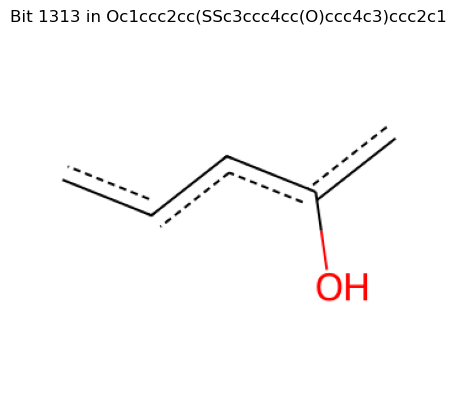

In [46]:
for smi in df_test_random_split['SMILES']:
    mol = Chem.MolFromSmiles(smi)
    bitInfo = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bitInfo)

    if bit_id in bitInfo:
        print(f"Бит {bit_id} найден в молекуле {smi}")
        atom_id, radius = bitInfo[bit_id][0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_id)
        amap = {}
        submol = Chem.PathToSubmol(mol, env, atomMap=amap)
        img = Draw.MolToImage(submol, size=(300, 300))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Bit {bit_id} in {smi}')
        plt.show()
        break  # остановимся после первой найденной

In [48]:
df_test_random_split[df_test_random_split['SMILES'] == 'Oc1ccc2cc(SSc3ccc4cc(O)ccc4c3)ccc2c1']

,SMILES,toxicity,mol,scaffold
165,Oc1ccc2cc(SSc3ccc4cc(O)ccc4c3)ccc2c1,1.0,<rdkit.Chem.rdchem.Mol object at 0x7f4a051d74c0>,C1CCC2CC(CCC3CCC4CCCCC4C3)CCC2C1


Подструктура с фенильным кольцом и гидроксильной группой (OH), окружённая двойными связями - важный признак оценки классификации токсичности молекул

In [ ]:
# Пример молекулы, но можно взять любую из твоего df_test_random_split
mol = df_test_random_split.iloc[0]['mol']
smi = df_test_random_split.iloc[0]['SMILES']

# Создаём ECFP4 с сохранением bitInfo
bitInfo = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bitInfo)

# Покажем, сколько битов установлено
on_bits = list(fp.GetOnBits())
print(f"{len(on_bits)} bits set: {on_bits[:5]}...")


bit_id = top_indices[0]

# Проверим, есть ли бит в текущей молекуле
if bit_id not in bitInfo:
    print(f"Bit {bit_id} не найден в молекуле {smi}")
else:
    atom_id, radius = bitInfo[bit_id][0]
    env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_id)
    amap = {}
    submol = Chem.PathToSubmol(mol, env, atomMap=amap)

    # Визуализируем
    img = Draw.MolToImage(submol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Bit {bit_id} (radius={radius})')
    plt.show()

Bit 1313 не найден в молекуле CCOc1cc(OCC)c(C(=O)CCC(=O)O)cc1OCC


In [74]:
df_test_reindexed = df_test_random_split.reset_index(drop=True)

In [69]:
def class_scaffolds(df):
    scaffold_classes = {}
    grouped = df.groupby('scaffold')['toxicity']
    for scaffold, values in grouped:
        unique_vals = set(values)
        if unique_vals == {1}:
            scaffold_classes[scaffold] = '1'
        elif unique_vals == {0}:
            scaffold_classes[scaffold] = '0'
        else:
            scaffold_classes[scaffold] = '0_1'
    return scaffold_classes

scaffold_classes = class_scaffolds(df_test_random_split)

In [78]:
train_scaffold_counts = df_train_random_split['scaffold'].value_counts().to_dict()
test_scaffold_counts = df_test_random_split['scaffold'].value_counts().to_dict()

In [ ]:
def compute_scaffold_metrics(df_test_reindexed, scaffolds=None):
    scaffold_metrics = []
    if scaffolds is None:
        scaffolds = df_test_reindexed['scaffold'].unique()

    for scaffold in scaffolds:
        idx = df_test_reindexed[df_test_reindexed['scaffold'] == scaffold].index
        y_test_sample = y_test[idx]
        y_pred_sample = y_pred[idx]
        y_proba_sample = y_proba[idx]
        counts_class = scaffold_classes[scaffold]

        metrics_sample = compute_metrics(y_test_sample, y_pred_sample, y_proba_sample)
        scaffold_metrics.append({'scaffold': scaffold, 'counts_class': counts_class, **metrics_sample,
                                 'train_scaffold_count': train_scaffold_counts.get(scaffold, 0),
                                 'test_scaffold_count': test_scaffold_counts.get(scaffold, 0)})

    return pd.DataFrame(scaffold_metrics)

scaffold_metrics_df = compute_scaffold_metrics(df_test_reindexed, df_test_random_split['scaffold'].unique())

/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/nfs_protein/gavrilenko/envs/toxicity_prediction/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [84]:
scaffold_metrics_both_classes = scaffold_metrics_df[scaffold_metrics_df['counts_class'] == '0_1']
scaffold_metrics_both_classes

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc,train_scaffold_count,test_scaffold_count
0,C1CCCCC1,0_1,0.200000,0.363636,0.853211,0.258065,0.670350,1269,240
1,,0_1,0.142857,0.058824,0.973333,0.083333,0.703529,1225,242
3,C1CCC2CCCCC2C1,0_1,1.000000,0.500000,1.000000,0.666667,0.900000,87,22
4,C1CCC(CCC2CCCCC2)CC1,0_1,0.666667,0.666667,0.714286,0.666667,0.833333,36,13
6,CC(CC1CCCCC1)CC1CCCCC1,0_1,0.000000,0.000000,0.666667,0.000000,0.444444,10,6
7,CC(C1CCCCC1)C1CCCCC1,0_1,1.000000,1.000000,1.000000,1.000000,1.000000,37,4
12,C1CCC2CC3CCCCC3CCC2C1,0_1,0.000000,0.000000,1.000000,0.000000,1.000000,6,4
14,C1CCC(C2CCCCC2)CC1,0_1,0.000000,0.000000,0.857143,0.000000,0.750000,46,16
17,C1CCC(CCC2CCCC3CCCCC32)CC1,0_1,1.000000,1.000000,1.000000,1.000000,1.000000,5,3
24,CC1CCC2C(CCC3C4CCCC4CCC23)C1,0_1,0.714286,1.000000,0.500000,0.833333,1.000000,69,9


* Частотные скаффолды предсказываются ограниченно

    ```C1CCCCC1```, ```-``` это  простые, циклические или алкановые скаффолды, часто встречающиеся в наборах данных

    Может быть связано с химическим однообразием: такие структуры часто встречаются и в токсичных, и в нетоксичных соединениях → низкая специфичность признаков.

* Многоядерные или разветвлённые скаффолды предсказываются лучше

    ```C1CCC2C(C1)CC1CCCCC12```, ```C1CCC(C2CCC3CCC4C5CC(C6CCCCC6)CC5CCC4C3C2)CC1```

    Структурная уникальность → ECFP позволяет легко отличить токсичную структуру.

* Есть скаффолды с нулевыми precision/recall/f1, но sensitivity = 1.0
       
    Модель всегда для них предсказывает ноль

    ```CC(CCCC1CCCCC1)C1CCCCC1```, ```CC(CC1CCCCC1)(CC1CCCCC1)CC1CCCCC1```

* Скаффолд ```CC1C2CCCCC2CC(C2CCCCC2)C1CC1CCCC(CCC2CCCCC2)C1``` в трейне не встречается, но в тесте предсказывается верно 

In [88]:
scaffold_metrics_pos_class = scaffold_metrics_df[scaffold_metrics_df['counts_class'] == '1']

In [102]:
scaffold_metrics_pos_class.sample(10)

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc,train_scaffold_count,test_scaffold_count
265,C1CCC2CCCCC2C1.C1CCCCC1,1,0.0,0.0,0.0,0.0,NaN,0,1
146,CC1CCC(C2CCCC2)C(C)C1,1,0.0,0.0,0.0,0.0,NaN,9,1
169,CC1C2CCCCC2CCC1C1CCCCC1,1,1.0,1.0,0.0,1.0,NaN,8,1
124,CC(CC1CCCCC1)C1CCC(C2CCCCC2)C1C1CCCCC1.CC(CC1C...,1,0.0,0.0,0.0,0.0,NaN,0,1
112,CC(CC(C)(C)CCC1CCCC1)C1CCCCC1,1,0.0,0.0,0.0,0.0,NaN,0,1
142,C1CCCCC1.CC1CCC2C1CCC1C3CCCCC3CCC21,1,1.0,1.0,0.0,1.0,NaN,0,1
117,C1CC2CCC3C4CC5CC5CC4CCC3C2C1,1,1.0,1.0,0.0,1.0,NaN,0,1
239,CC1C2CCCCC2CC1C1CCCCC1,1,0.0,0.0,0.0,0.0,NaN,0,1
70,C1CCC2C(C1)CCCC2CC1CC2CCC1CC2,1,1.0,1.0,0.0,1.0,NaN,3,1
155,CC(CC1C(C)C2CCCC21)C1CCCCC1,1,0.0,0.0,0.0,0.0,NaN,1,1


In [90]:
(scaffold_metrics_pos_class['f1'] == 1).sum() / len(scaffold_metrics_pos_class)

0.3870967741935484

38 процентов положительных скаффолдов классифицированы верно

In [92]:
scaffold_metrics_neg_class = scaffold_metrics_df[scaffold_metrics_df['counts_class'] == '0']

In [101]:
scaffold_metrics_neg_class.sample(10)

,scaffold,counts_class,precision,recall,sensitivity,f1,roc_auc,train_scaffold_count,test_scaffold_count
130,CC(C)(CC1CCCCC1)C1CC2CCCCC2C1,0,0.0,0.0,1.0,0.0,NaN,2,1
27,CC(CC1C2CCC3C4CC5C6CCCC5(C4CC6)C(C2)C13)C1CCCCC1,0,0.0,0.0,1.0,0.0,NaN,0,1
45,C1CCC(CCC2CCC3CCCCC32)CC1,0,0.0,0.0,1.0,0.0,NaN,0,1
214,C1CCC(CCCC2CCC3CCCCC3C2)C1,0,0.0,0.0,1.0,0.0,NaN,0,1
245,CC1CC(CCC(C)C2CCCC2)CC(C(C)CCC2CCCCC2)C1,0,0.0,0.0,1.0,0.0,NaN,0,1
157,CC1CC2CCC(C3CCCCC3)CC2CC1C,0,0.0,0.0,1.0,0.0,NaN,0,1
91,CC1CCCCCCCCCCCC(CC2CCC(CC3CCCCC3)CC2)CCC1,0,0.0,0.0,0.0,0.0,NaN,2,1
227,CC(CC1CCCCC1)CC(C)(C)C1CCC(CCCC(C)C2CCCC2C)CC1,0,0.0,0.0,1.0,0.0,NaN,0,1
216,CC1CC(C)CC(CCCCCCCC2CCCCC2)C1,0,0.0,0.0,1.0,0.0,NaN,0,1
63,CC(CC1CC2C(CC(C)C3CCCC32)C1C)C1CCC2CC3CCC4CCCC...,0,0.0,0.0,1.0,0.0,NaN,1,1


In [99]:
(scaffold_metrics_neg_class['sensitivity'] == 1).sum() / len(scaffold_metrics_neg_class)

0.8960396039603961

89 процентов негативных скаффолдов классифицированы верно